The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [1]:
#cell 1
%matplotlib inline

In [2]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 Grizli version:  0.8.0-45-g977ade9


In [3]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [4]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1     811.7
filter j105908m1246          WFC3/IR G102    1    4711.7


 1 j105900m1253 164.747 -12.878
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1     460.0
filter j105900m1253         WFC3/IR F105W    1     811.7
filter j105900m1253          WFC3/IR G102    1    4711.7


 2 j105912m1254 164.794 -12.903
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1     811.7
filter j105912m1254          WFC3/IR G102    1    4711.7


 3 j105836m1254 164.644 -12.893
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1     811.7
filter j105836m1254          WFC3/IR G102    1    4711.7


 4 j113812m1134 174.554 -11.573
target_name
-----------
CL1138-11.0 

filter j113812m1134         WFC3/IR F105W    1     811.7
filter j113812m1134          WFC3/IR

In [5]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [6]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [8]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j130132m1138'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [9]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

gunzip ic1b11lcq_raw.fits.gz  # status="0"
gunzip ic1b11ljq_raw.fits.gz  # status="0"
gunzip ic1b11l0q_raw.fits.gz  # status="0"
gunzip ic1b11l5q_raw.fits.gz  # status="0"
gunzip ic1b11kxq_raw.fits.gz  # status="0"
gunzip ic1b11llq_raw.fits.gz  # status="0"
gunzip ic1b11leq_raw.fits.gz  # status="0"
gunzip ic1b11l7q_raw.fits.gz  # status="0"
gunzip jc1b15r0q_flc.fits.gz  # status="0"
gunzip jc1b15qeq_flc.fits.gz  # status="0"
gunzip jc1b15qtq_flc.fits.gz  # status="0"
gunzip jc1b15qmq_flc.fits.gz  # status="0"
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=jref$0461802dj_idc.fits
/home/jrcooper/grizli/jref/0461802dj_i

## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [10]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1301-11.0-c1b-11-136.0-F105W 4
CL1301-11.0-c1b-11-136.0-G102 4
jc1b15-c1b-15-308.0-F814W 4

 == Grism groups ==

ic1b-136.0-f105w 4 ic1b-136.0-g102 4


ic1b-136.0-f105w                4
ic1b-136.0-g102                 4
ic1b-308.0-f814w                4


In [11]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1301-11.0-c1b-11-136.0-F105W 4
CL1301-11.0-c1b-11-136.0-G102 4
jc1b15-c1b-15-308.0-F814W 4

 == Grism groups ==

cl1301-11.0-c1b-11-136.0-f105w 4 cl1301-11.0-c1b-11-136.0-g102 4


cl1301-11.0-c1b-11-136.0-f105w  4
cl1301-11.0-c1b-11-136.0-g102   4
jc1b15-c1b-15-308.0-f814w       4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [12]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1301-11.0-c1b-11-136.0-f105w 4 cl1301-11.0-c1b-11-136.0-g102 4



cl1301-11.0-c1b-11-136.0-f105w radec: None



../RAW/ic1b11kxq_flt.fits -> ic1b11kxq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/ic1b11l5q_flt.fits -> ic1b11l5q_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/ic1b11lcq_flt.fits -> ic1b11lcq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
Region mask for ic1b11lcq_flt.fits: ['ic1b11lcq.01.mask.reg']
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/ic1b11ljq_flt.fits -> ic1b11ljq_flt.fits  / bpix: $iref/badpix_spars200_Nov9.fits
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
- IDCTAB: Distortion model from row 1 for chip 1 : F105W
../RAW/ic1

==== Processing Step  Separate Drizzle  finished at  07:51:31.186 (06/02/2019)

==== Processing Step  Create Median  started at  07:51:31.191 (06/02/2019)
reference sky value for image 'ic1b11kxq_flt.fits' is 168.89454529584037
reference sky value for image 'ic1b11l5q_flt.fits' is 162.1634866424099
reference sky value for image 'ic1b11lcq_flt.fits' is 190.403942283197
reference sky value for image 'ic1b11ljq_flt.fits' is 163.6226939191736
Saving output median image to: 'cl1301-11.0-c1b-11-136.0-f105w_med.fits'
==== Processing Step  Create Median  finished at  07:51:31.608 (06/02/2019)

==== Processing Step  Blot  started at  07:51:31.609 (06/02/2019)
    Blot: creating blotted image:  ic1b11kxq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ic1b11kxq_sci1_blt.fits
Writing out image to disk: ic1b11kxq_sci1_blt.fits
    Blot: creating blotted image:  ic1b11l5q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generatin

/home/jrcooper/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/astropy/table/row.py:65: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


cl1301-11.0-c1b-11-136.0-f105w (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=9, Nout=9, match=9
  tristars.match: Nin=8, Nout=8, match=8
cl1301-11.0-c1b-11-136.0-f105w (0) 8:  -1.80   0.82  -0.000   1.000
  tristars.match: Nin=9, Nout=9, match=9
  tristars.match: Nin=8, Nout=8, match=8
cl1301-11.0-c1b-11-136.0-f105w (1) 8:   0.00  -0.00   0.000   1.000
  tristars.match: Nin=9, Nout=9, match=9
  tristars.match: Nin=8, Nout=8, match=8
cl1301-11.0-c1b-11-136.0-f105w (2) 8:  -0.00   0.00  -0.000   1.000
Initialize cl1301-11.0-c1b-11-136.0-f105w_wcs.log

....Updating header for ic1b11kxq_flt.fits...


Processing ic1b11kxq_flt.fits['SCI',1]

Updating header for ic1b11kxq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.761158789573515e-05 -5.678805630088647e-07
CD_21  CD_22: -7.595202222668742e-07 -3.3599608149232804e-05
CRVAL    : 195.37967335301292 -11.62429934052302
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544865641375792
ORIENTAT : -179.03171305589507
WCSN

Writing out image to disk: ic1b11kxq_sci1_blt.fits
    Blot: creating blotted image:  ic1b11l5q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ic1b11l5q_sci1_blt.fits
Writing out image to disk: ic1b11l5q_sci1_blt.fits
    Blot: creating blotted image:  ic1b11lcq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ic1b11lcq_sci1_blt.fits
Writing out image to disk: ic1b11lcq_sci1_blt.fits
    Blot: creating blotted image:  ic1b11ljq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ic1b11ljq_sci1_blt.fits
Writing out image to disk: ic1b11ljq_sci1_blt.fits
==== Processing Step  Blot  finished at  07:51:43.953 (06/02/2019)

==== Processing Step  Driz_CR  started at  07:51:43.955 (06/02/2019)
Creating output :  ic1b11l5q_sci1_crmask.fits
Creating output :  ic1b11ljq_sci1_crmask.fits
Creating output :  ic1b11kxq_sci1_crmask.fits
Creating output :

       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----

   **  Input image: 'ic1b11l0q_flt.fits'
       EXT: 'SCI',1;	MASK: ic1b11l0q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ic1b11l7q_flt.fits'
       EXT: 'SCI',1;	MASK: ic1b11l7q_skymatch_mask_sci1.fits[0]

   **  Input image: 'ic1b11leq_flt.fits'
       EXT: 'SCI',1;	MASK: ic1b11leq_skymatch_mask_sci1.fits[0]

   **  Input image: 'ic1b11llq_flt.fits'
       EXT: 'SCI',1;	MASK: ic1b11llq_skymatch_mask_sci1.fits[0]

-----  Sky statistics parameters:  -----
       statistics function: 'median'
       lower = None
       upper = None
       nclip = 5
       lsigma = 4.0
       usigma = 4.0
       binwidth = 0.1

-----  Data->Brightness conversion parameters for input files:  -----

   *   Image: ic1b11l0q_flt.fits
       EXT = 'SCI',1
             Data units type: COUNT-RATE
             Conversion factor (data->brightness):  60.797431635711504

   *   Image: ic1b11l7q_flt.fits
       EXT = 'SCI',1
             Data

/home/jrcooper/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-0.8.0_45_g977ade9-py3.6-linux-x86_64.egg/grizli/prep.py:3620: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A[mask & obj_mask,:], data[mask & obj_mask])


   cl1301-11.0-c1b-11-136.0-g102 > Iter: 2, masked: 55%, [ 0.8021432  -0.05439085  0.5901638  -0.04865328  0.2904005 ]
   cl1301-11.0-c1b-11-136.0-g102 > Iter: 3, masked: 54%, [ 0.80514526 -0.05877981  0.58558476 -0.05307412  0.2872172 ]
   cl1301-11.0-c1b-11-136.0-g102 > Iter: 4, masked: 54%, [ 0.8053322  -0.05918843  0.58517754 -0.05350776  0.2869927 ]


/home/jrcooper/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/jrcooper/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/jrcooper/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/jrcooper/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 07:52:46.259 (06/02/2019)

==== Processing Step  Initialization  started at  07:52:46.262 (06/02/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 195.37965401849152  -11.624433178218341  
CRPIX : 549.0  484.0  
CD1_1 CD1_2  : 3.5615416780642866e-05  -8.262984724144795e-07  
CD2_1 CD2_2  : -8.262984724144795e-07  -3.5615416780642866e-05  
NAXIS : 1098  968
********************************************************************************
*
*  Estimated memory usage:  up to 80 Mb.
*  Output image size:       1098 X 968 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  07:52:47.1 (06/02/2019)

==== Processing Step  Static Mask  started at  07:52:47.201 (06/02/2019)
==== Processing Step  Static M

Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 6 for chip 2 : F814W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 6 for chip 2 : F814W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 5 for chip 1 : F814W
../RAW/jc1b15r0q_flc.fits -> jc1b15r0q_flc.fits 
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 6 for chip 2 : F814W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 6 for chip 2 : F814W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 5 for chip 1 : F814W
Query NOAO Source Catalog (195.36600,-11.59178,3.0')
Query NOAO source catalog
Created TAP+ (v1.0.1) - Connection:
	Host: datalab.noao.edu
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Launched query: 'SELECT TOP 100000 * FROM nsc_dr1.object  WHERE nsc_dr1.o

reference sky value for image 'jc1b15qeq_flc.fits' is 10.051924705505371
reference sky value for image 'jc1b15qmq_flc.fits' is 10.826385498046875
reference sky value for image 'jc1b15qtq_flc.fits' is 14.362570762634277
reference sky value for image 'jc1b15r0q_flc.fits' is 9.69403076171875
Saving output median image to: 'jc1b15-c1b-15-308.0-f814w_med.fits'
==== Processing Step  Create Median  finished at  07:53:30.148 (06/02/2019)

==== Processing Step  Blot  started at  07:53:30.149 (06/02/2019)
    Blot: creating blotted image:  jc1b15qeq_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: jc1b15qeq_sci1_blt.fits
Writing out image to disk: jc1b15qeq_sci1_blt.fits
    Blot: creating blotted image:  jc1b15qeq_flc.fits[sci,2]
Using default C-based coordinate transformation...
-Generating simple FITS output: jc1b15qeq_sci2_blt.fits
Writing out image to disk: jc1b15qeq_sci2_blt.fits
    Blot: creating blotted image:  jc1b15qmq_flc.fits[sci,1]


/home/jrcooper/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/astropy/table/row.py:65: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


jc1b15-c1b-15-308.0-f814w (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=9, Nout=9, match=9
  tristars.match: Nin=8, Nout=8, match=8
jc1b15-c1b-15-308.0-f814w (0) 8:  -0.20  11.61  -0.011   1.000
  tristars.match: Nin=9, Nout=9, match=9
  tristars.match: Nin=8, Nout=8, match=8
jc1b15-c1b-15-308.0-f814w (1) 8:  -0.00   0.00  -0.000   1.000
  tristars.match: Nin=9, Nout=9, match=9
  tristars.match: Nin=8, Nout=8, match=8
jc1b15-c1b-15-308.0-f814w (2) 8:   0.00  -0.00   0.000   1.000
Initialize jc1b15-c1b-15-308.0-f814w_wcs.log

....Updating header for jc1b15qeq_flc.fits...


Processing jc1b15qeq_flc.fits['SCI',1]

Updating header for jc1b15qeq_flc.fits[1]
WCS Keywords

CD_11  CD_12: 8.8836996701778e-06 1.131309548670673e-05
CD_21  CD_22: 1.062155248679587e-05 -8.20489624104875e-06
CRVAL    : 195.36587650037572 -11.591671060212036
CRPIX    : 2048.0 1024.0
NAXIS    : 4096 2048
Plate Scale : 0.04984355003928518
ORIENTAT : 125.95174438923249
WCSNAME  :  NSC

Processing jc1b1

   *   Image:   'jc1b15qmq_flc.fits['SCI',1,2]'  --  SKY = 43.30554199218749 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 10.8264   NEW MDRIZSKY = 10.8264
      - EXT = 'SCI',2   delta(MDRIZSKY) = 10.8264   NEW MDRIZSKY = 10.8264
   *   Image:   'jc1b15qtq_flc.fits['SCI',1,2]'  --  SKY = 47.875235875447586 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 14.3626   NEW MDRIZSKY = 14.3626
      - EXT = 'SCI',2   delta(MDRIZSKY) = 14.3626   NEW MDRIZSKY = 14.3626
   *   Image:   'jc1b15r0q_flc.fits['SCI',1,2]'  --  SKY = 32.31343587239583 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 9.69403   NEW MDRIZSKY = 9.69403
      - EXT = 'SCI',2   delta(MDRIZSKY) = 9.69403   NEW MDRIZSKY = 9.69403
***** skymatch ended on 2019-02-06 07:56:03.077620
TOTAL RUN TIME: 0:00:06.603948
==== Processing Step  Subtract Sky  finished at  07:56:03.301 (06/02/2019)

==== Pr

utils.fix_flt_nan: ic1b11kxq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b11leq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b15qmq_flc.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: jc1b15qmq_flc.fits[SCI,2] NaNPixels=0
utils.fix_flt_nan: ic1b11lcq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b11ljq_flt.fits[SCI,1] NaNPixels=0


In [13]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [14]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1301-11.0-c1b-11-136.0-f105w_shifts.log  jc1b15-c1b-15-308.0-f814w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b11kxq_flt.fits'] = ['ic1b11l0q_flt.fits']
# match['ic1b11l5q_flt.fits'] = ['ic1b11l7q_flt.fits']
# match['ic1b11lcq_flt.fits'] = ['ic1b11leq_flt.fits']
# match['ic1b11ljq_flt.fits'] = ['ic1b11llq_flt.fits']
ic1b11kxq_flt.fits  -0.000  -0.000  0.00000  1.00000    50  0.000  0.000
ic1b11l5q_flt.fits   0.014   0.034  0.00000  1.00000    45  0.048  0.074
ic1b11lcq_flt.fits   0.006   0.016  0.00000  1.00000    30  0.045  0.075
ic1b11ljq_flt.fits   0.014   0.055  0.00000  1.00000    44  0.033  0.054
# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['jc1b15qeq_flc.fits'] = []
# match['jc1b15qmq_flc.fits'] = []
# match['jc1b15qtq_flc.fits'] = []
# match['jc1b15r0q_flc.fits'] = []
jc1b15qeq_flc.fits   0.000  -0.000  0.00000  1.00000    50  0.000  0.000
jc1b15qmq_flc.fits   0.021   0.060  0.00000  1.00000    44  0.108  0.074
jc1b1

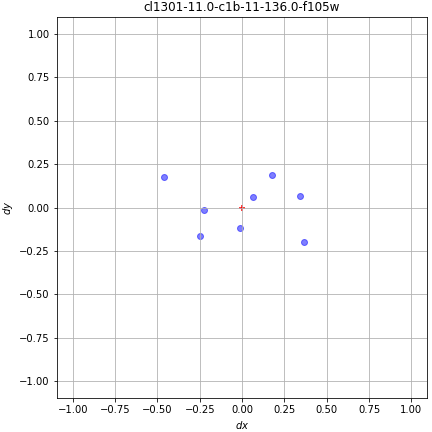

In [15]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1301-11.0-c1b-11-136.0-f105w_wcs.png") 


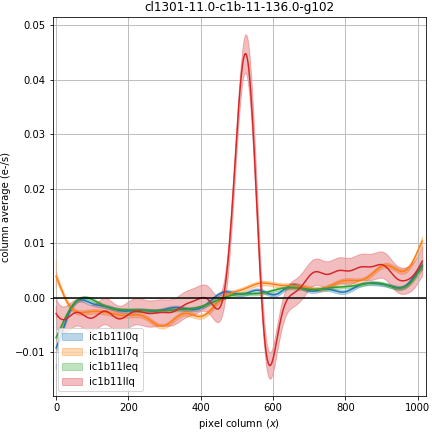

In [16]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1301-11.0-c1b-11-136.0-g102_column.png") 

In [17]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

cl1301-11.0-c1b-11-136.0-f105w_wcs.log: 0 -1.7968 0.8152 0.0002 1.00014 0.156 8
jc1b15-c1b-15-308.0-f814w_wcs.log: 0 -0.2045 11.6090 0.0106 0.99989 0.152 8


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [18]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

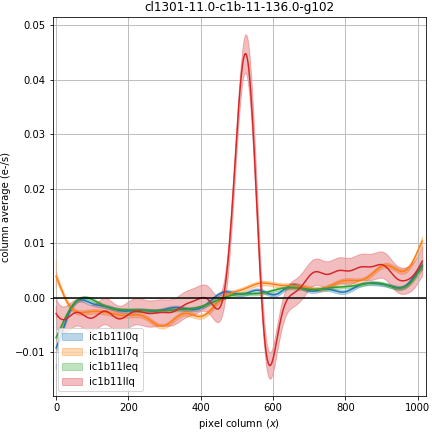

In [19]:
from IPython.display import Image
Image(filename = "./cl1301-11.0-c1b-11-136.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

Center coordinate:  195.379 -11.626
SELECT TOP 100000 * FROM gaiadr2.gaia_source  WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',195.379,-11.626,0.17))=1
Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1549461761508O
Job id: 1549461761508O
Status: COMPLETED
Data saved in: gaia.fits.gz
j130132m1138 - Reference RADEC: j130132m1138_gaia.radec [GAIA] N=439
SELECT TOP 100000 * FROM gaiadr2.gaia_source  WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',195.3796477712952,-11.62445074599304,0.08))=1
Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1549461763709O
Job id: 1549461763709O
Status: COMPLETED
Data saved in: gaia.fits.gz


/home/jrcooper/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-0.8.0_45_g977ade9-py3.6-linux-x86_64.egg/grizli/prep.py:1825: TableReplaceWarning: converted column 'priam_flags' from integer to float
  g = pyia.GaiaData(gaia_tbl)
/home/jrcooper/anaconda3/envs/grizli-dev/lib/python3.6/site-packages/grizli-0.8.0_45_g977ade9-py3.6-linux-x86_64.egg/grizli/prep.py:1825: TableReplaceWarning: converted column 'flame_flags' from integer to float
  g = pyia.GaiaData(gaia_tbl)


Apply observation (56375.81697556,mjd) to GAIA catalog
cl1301-11.0-c1b-11-136.0 - Reference RADEC: cl1301-11.0-c1b-11-136.0_gaia.radec [GAIA] N=85
cl1301-11.0-c1b-11-136.0-f105w_drz_sci.fits Ncat=132 Nref=2
SELECT TOP 100000 * FROM gaiadr2.gaia_source  WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',195.3780045312737,-11.6000226358731,0.08))=1
Status: 303 Reason: 303
Location: http://gea.esac.esa.int/tap-server/tap/async/1549461765557O
Job id: 1549461765557O
Status: COMPLETED
Data saved in: gaia.fits.gz
Apply observation (56442.21911203,mjd) to GAIA catalog
jc1b15-c1b-15-308.0 - Reference RADEC: jc1b15-c1b-15-308.0_gaia.radec [GAIA] N=89
jc1b15-c1b-15-308.0-f814w_drc_sci.fits Ncat=169 Nref=14
cl1301-11.0-c1b-11-136.0-f105w.cat.fits jc1b15-c1b-15-308.0-f814w.cat.fits 38
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]
[[ 0.1  0.   0.   1. ]
 [ 0.   0.   0.   1. ]]
[[-0.162  0.     0.     1.   ]
 [ 0.     0.     0.   

[[-0.166  0.091  0.     1.   ]
 [-0.355 -0.102  0.     1.   ]]
[[-0.166  0.091  0.     1.   ]
 [-0.355 -0.102  0.     1.   ]]
[[-0.208  0.104  0.     1.   ]
 [-0.406 -0.099  0.     1.   ]]
[[-0.099  0.07   0.     1.   ]
 [-0.273 -0.106  0.     1.   ]]
[[-0.166  0.091  0.     1.   ]
 [-0.355 -0.102  0.     1.   ]]
[[-0.141  0.083  0.     1.   ]
 [-0.324 -0.103  0.     1.   ]]
[[-0.182  0.096  0.     1.   ]
 [-0.374 -0.101  0.     1.   ]]
[[-0.164  0.09   0.     1.   ]
 [-0.352 -0.102  0.     1.   ]]
[[-0.159  0.089  0.     1.   ]
 [-0.346 -0.102  0.     1.   ]]
[[-0.152  0.087  0.     1.   ]
 [-0.338 -0.103  0.     1.   ]]
[[-0.161  0.09   0.     1.   ]
 [-0.349 -0.102  0.     1.   ]]
[[-0.161  0.09   0.     1.   ]
 [-0.349 -0.102  0.     1.   ]]
[[-0.161  0.09   0.     1.   ]
 [-0.349 -0.102  0.     1.   ]]
[[-0.161  0.09   0.     1.   ]
 [-0.349 -0.102  0.     1.   ]]
[[-0.172  0.1    0.     1.   ]
 [-0.402 -0.123  0.     1.   ]]
[[-0.144  0.073  0.     1.   ]
 [-0.263 -0.068  0.     

[[-0.154  0.1    0.     1.   ]
 [-0.372 -0.051  0.     1.   ]]
[[-0.154  0.1    0.     1.   ]
 [-0.372 -0.051  0.     1.   ]]
ic1b11kxq_flt.fits
ic1b11l5q_flt.fits
ic1b11lcq_flt.fits
ic1b11ljq_flt.fits
jc1b15qeq_flc.fits
jc1b15qmq_flc.fits
jc1b15qtq_flc.fits
jc1b15r0q_flc.fits

....Updating header for ic1b11kxq_flt.fits...


Processing ic1b11kxq_flt.fits['SCI',1]

Updating header for ic1b11kxq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.761158790531655e-05 -5.678798931948822e-07
CD_21  CD_22: -7.59519477975766e-07 -3.3599608156362354e-05
CRVAL    : 195.3796790436471 -11.624295911288792
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542932126569174
ORIENTAT : -179.03171419797556
WCSNAME  :  FINE

....Updating header for ic1b11l5q_flt.fits...


Processing ic1b11l5q_flt.fits['SCI',1]

Updating header for ic1b11l5q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.761067010958069e-05 -5.679288561128898e-07
CD_21  CD_22: -7.595712485443018e-07 -3.359878840337138e-05
CRVAL    : 195.3792

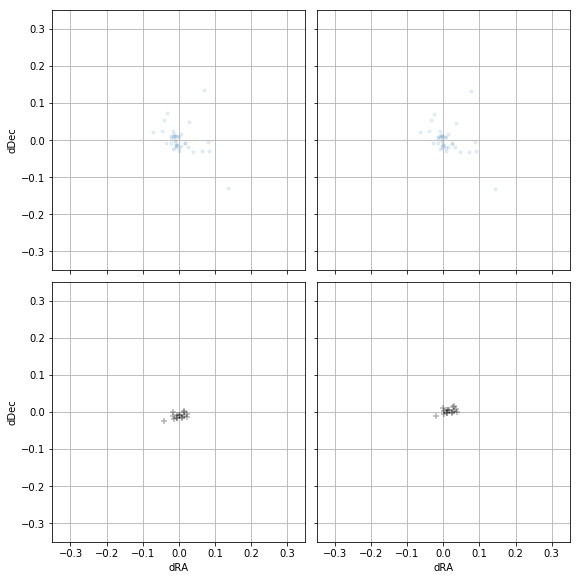

In [20]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

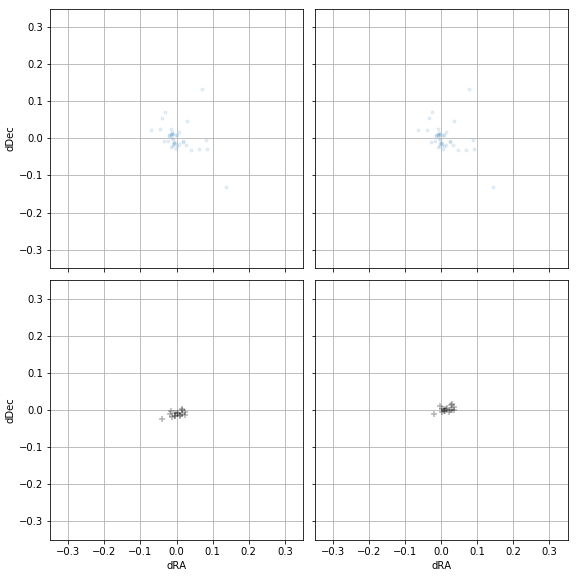

In [21]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [22]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

  0/  4: ic1b11l0q_flt.fits[SCI,1]    4.67
  1/  4: ic1b11l7q_flt.fits[SCI,1]    4.73
  2/  4: ic1b11leq_flt.fits[SCI,1]    4.76
  3/  4: ic1b11llq_flt.fits[SCI,1]    4.78

  Mosaic WCS: (195.37932,-11.62446)  3.9'x3.6'  0.060"/pix

Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 08:02:59.484 (06/02/2019)

==== Processing Step  Initialization  started at  08:02:59.486 (06/02/2019)
Creating OUTPUT WCS from j130132m1138_wcs-ref.fits[1]
WCS Keywords

CD_11  CD_12: -1.6666666666666e-05 0.0
CD_21  CD_22: 0.0 1.66666666666666e-05
CRVAL    : 195.3793228322264 -11.624462692855
CRPIX    : 2675.0 2554.0
NAXIS    : 5350 5108
Plate Scale : 0.0599999999999976
ORIENTAT : 0.0
********************************************************************************
*
*  Estimated memory usage:  up to 320 Mb.
*  Output image size:       5350 X 5108 pixels. 
*  Output image file:       ~ 312 Mb. 
*  Cores available:         1
*
***************************

==== Processing Step  Blot  started at  08:03:48.016 (06/02/2019)
==== Processing Step  Blot  finished at  08:03:48.017 (06/02/2019)

==== Processing Step  Driz_CR  started at  08:03:48.019 (06/02/2019)
==== Processing Step  Final Drizzle  started at  08:03:48.020 (06/02/2019)
WCS Keywords

CD_11  CD_12: -1.6666666666666e-05 0.0
CD_21  CD_22: 0.0 1.66666666666666e-05
CRVAL    : 195.3793228322264 -11.624462692855
CRPIX    : 2675.0 2554.0
NAXIS    : 5350 5108
Plate Scale : 0.0599999999999976
ORIENTAT : 0.0
-Generating simple FITS output: j130132m1138-f814w_drc_sci.fits
Writing out image to disk: j130132m1138-f814w_drc_sci.fits
Writing out image to disk: j130132m1138-f814w_drc_wht.fits
==== Processing Step  Final Drizzle  finished at  08:04:17.626 (06/02/2019)


AstroDrizzle Version 2.2.6 is finished processing at 08:04:17.629 (06/02/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          ---------------

In [23]:
!ls -1 j*_dr?_sci.fits

j130132m1138-f105w_drz_sci.fits
j130132m1138-f814w_drc_sci.fits
j130132m1138-ir_drc_sci.fits
jc1b15-c1b-15-308.0-f814w_drc_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [24]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

Image AB zeropoint: 26.269
SEP: err_scale=0.898
   SEP: Extract...
    Done.
j130132m1138-ir.cat.fits: 662 objects
f105w
Image AB zeropoint: 26.269
SEP: err_scale=0.515
j130132m1138-f105w.cat.fits: 662 objects
f814w
Image AB zeropoint: 25.946
SEP: err_scale=1.014
j130132m1138-f814w.cat.fits: 662 objects
g102
j130132m1138-ir_drc_wht.fits
j130132m1138-ir_seg.fits
j130132m1138-ir.cat.fits
j130132m1138-ir_bkg.fits
j130132m1138-ir_drc_sci.fits
j130132m1138_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j130132m1138-ir_drc_sci.fits
WHT_FILE:	j130132m1138-ir_drc_wht.fits
GET_BACK:	False
ERR_SCALE:	0.8981928825378418
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	105

In [25]:
phot[:2].show_in_notebook()

idx,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x_image,y_image,x2_image,y2_image,xy_image,errx2,erry2,errxy,a_image,b_image,theta_image,cxx_image,cyy_image,cxy_image,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,number,ra,dec,x_world,y_world,flux_auto,fluxerr_auto,flux_bkg_auto,mag_auto_raw,magerr_auto_raw,mag_auto,magerr_auto,kron_radius,kron_flag,kron_flux_flag,flux_radius,flux_radius_90,flux_aper_0,fluxerr_aper_0,flag_aper_0,bkg_aper_0,mask_aper_0,flux_aper_1,fluxerr_aper_1,flag_aper_1,bkg_aper_1,mask_aper_1,flux_aper_2,fluxerr_aper_2,flag_aper_2,bkg_aper_2,mask_aper_2,flux_aper_3,fluxerr_aper_3,flag_aper_3,bkg_aper_3,mask_aper_3,mag_iso,f105w_flux_aper_0,f105w_fluxerr_aper_0,f105w_flag_aper_0,f105w_bkg_aper_0,f105w_mask_aper_0,f105w_flux_aper_1,f105w_fluxerr_aper_1,f105w_flag_aper_1,f105w_bkg_aper_1,f105w_mask_aper_1,f105w_flux_aper_2,f105w_fluxerr_aper_2,f105w_flag_aper_2,f105w_bkg_aper_2,f105w_mask_aper_2,f105w_flux_aper_3,f105w_fluxerr_aper_3,f105w_flag_aper_3,f105w_bkg_aper_3,f105w_mask_aper_3,f814w_flux_aper_0,f814w_fluxerr_aper_0,f814w_flag_aper_0,f814w_bkg_aper_0,f814w_mask_aper_0,f814w_flux_aper_1,f814w_fluxerr_aper_1,f814w_flag_aper_1,f814w_bkg_aper_1,f814w_mask_aper_1,f814w_flux_aper_2,f814w_fluxerr_aper_2,f814w_flag_aper_2,f814w_bkg_aper_2,f814w_mask_aper_2,f814w_flux_aper_3,f814w_fluxerr_aper_3,f814w_flag_aper_3,f814w_bkg_aper_3,f814w_mask_aper_3
,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,uJy,uJy,,,,,,,deg,deg,deg,deg,uJy,uJy,,,,,,pix,,,pix,pix,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,,uJy,uJy,,,
0,0.04289570078253746,98,92,1763,1775,1512,1525,1770.024456059755,1519.2359533132803,6.423054181144245,6.67523999770539,1.2205857844487085,0.0070445249812675775,0.00802777608890196,0.001625232684851225,2.7885890007019043,2.306960344314575,0.8368682265281677,0.16129378974437714,0.15520022809505463,-0.05898601561784744,1.1757571342079827,1.2366377579889372,0.02431427539561914,0.030208270824172788,1769,1518,1769,1517,0,1,195.39472255045484,-11.641708350756256,195.39472255045484,-11.641708350756256,3.584543621357591,0.17746468630237722,0.0,22.513980947755915,0.053752961419272806,22.513980947755915,0.053752961419272806,7.128461692577622,0,0,8.095355298407537,16.245405663139522,0.615549767705325,0.022906008840110657,0,0.0,0.0,0.9231806423617682,0.031522776329466554,0,0.0,0.0,1.8073744204120348,0.06489937351925028,0,0.0,0.3600000000000001,2.144715018494908,0.08755232117180416,0,0.0,2.0,23.66939374354179,0.615549767705325,0.013987688269774944,0,0.0,0.0,0.9231806423617682,0.019009314550243354,0,0.0,0.0,1.8073744204120348,0.03810358928896741,0,0.0,0.3600000000000001,2.144715018494908,0.05097995530731403,0,0.0,2.0,0.0,0.0,0,0.0,28.239999999999995,0.0,0.0,0,0.0,54.60000000000001,0.0,0.0,0,0.0,209.44,0.0,0.0,0,0.0,314.0800000000001
1,0.059612590819597244,60,52,1536,1547,1526,1534,1542.7118584322716,1531.4628257181878,5.8177378043474945,3.1965917030975675,0.8818190553879788,0.013505894156928266,0.006540814572748721,0.00206810056278014,2.4671413898468018,1.7110062837600708,0.2961355745792389,0.17938901484012604,0.32648470997810364,-0.09897332638502121,0.658773754807685,0.7061812936567766,0.018334857793891397,0.031168060849376848,1541,1530,1542,1530,0,2,195.39859065162136,-11.6415043382959,195.39859065162136,-11.6415043382959,2.1146793778871706,0.257146512901325,0.0,23.086954296987766,0.13202629292352633,23.086954296987766,0.13202629292352633,7.010176838364773,0,0,6.543471863193515,13.321853907132503,0.4434464352645839,0.02167766888545967,0,0.0,0.0,0.6790851171871186,0.10171293396144482,0,0.0,0.0,1.315595190200999,0.22481282014102374,0,0.0,0.0,1.5524550886492292,0.23259164194400211,0,0.0,0.0,24.27770947708962,0.4434464352645839,0.013082326121256772,0,0.0,0.0,0.6797270871573257,0.05855045845400758,0,0.0,0.0,1.311439127642869,0.12917660295853073,0,0.0,0.0,1.5482990260910992,0.1336570665756284,0,0.0,0.0,0.0,0.0,0,0.0,28.360000000000003,0.0,0.0,0,0.0,54.83999999999999

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [26]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Image cutout: x=slice(328, 5046, None), y=slice(383, 4582, None)
ic1b11l0q_flt.fits / blot reference j130132m1138-f105w_drz_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(328, 5046, None), y=slice(383, 4582, None)
ic1b11l0q_flt.fits / Pad ref HDU with 50 pixels
ic1b11l0q_flt.fits / blot segmentation j130132m1138-ir_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(320, 5038, None), y=slice(396, 4595, None)
ic1b11llq_flt.fits / blot reference j130132m1138-f105w_drz_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(320, 5038, None), y=slice(396, 4595, None)
ic1b11llq_flt.fits / Pad ref HDU with 50 pixels
ic1b11llq_flt.fits / blot segmentation j130132m1138-ir_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(351, 5068, None), y=slice(391, 4589, Non

   70 mag= 23.50  4.90e-19 -1.40e-18 -4.97e-18  1.25e-16
  348 mag= 23.52  4.73e-18 -4.11e-17 -1.31e-16  1.51e-15 xx
   81 mag= 23.54  7.30e-19  4.07e-18  6.93e-18 -2.02e-17
  107 mag= 23.54  3.94e-19  1.68e-18 -5.56e-17  2.03e-16
  292 mag= 23.57  6.91e-19 -4.99e-18 -8.03e-18  1.54e-16
  231 mag= 23.59  3.21e-19  3.51e-20 -4.78e-18  4.02e-18
  129 mag= 23.60  5.79e-19 -1.89e-18 -1.57e-17  2.05e-17
  167 mag= 23.62  4.37e-19  2.34e-19 -8.76e-19  1.66e-17
  114 mag= 23.65 -1.77e-19 -9.81e-18 -5.19e-17 -2.35e-17 xx
  392 mag= 23.67  6.23e-19 -1.15e-18  8.85e-18  1.55e-17
   18 mag= 23.67  2.76e-19  5.25e-18 -9.72e-18 -6.83e-17
   65 mag= 23.69  3.96e-19  9.61e-19 -5.43e-18 -8.54e-17
  202 mag= 23.70  5.76e-19 -1.49e-18  1.56e-17  1.03e-16
   12 mag= 23.71 -4.33e-20  1.29e-18  1.18e-17  3.70e-17
  177 mag= 23.73  5.12e-19 -6.92e-19 -4.39e-18  2.64e-17
  319 mag= 23.74  3.44e-19 -2.43e-19 -2.94e-18  5.83e-17
  291 mag= 23.77  1.73e-19 -3.62e-19 -8.47e-18  5.63e-18
   78 mag= 23.77  1.30e-1

   70 mag= 23.50  5.01e-19 -1.82e-18 -4.15e-18  1.35e-16
  348 mag= 23.52  4.73e-18 -4.11e-17 -1.31e-16  1.51e-15 xx
   81 mag= 23.54  7.21e-19  3.21e-18 -1.45e-18 -5.00e-17
  107 mag= 23.54  3.93e-19  1.82e-18 -5.81e-17  2.14e-16
  292 mag= 23.57  6.67e-19 -5.10e-18 -2.20e-18  1.83e-16
  231 mag= 23.59  3.21e-19  2.97e-20 -4.76e-18  4.18e-18
  129 mag= 23.60  5.78e-19 -1.89e-18 -1.57e-17  2.05e-17
  167 mag= 23.62  4.37e-19  2.34e-19 -8.76e-19  1.66e-17
  114 mag= 23.65 -1.71e-19 -9.52e-18 -4.89e-17 -1.51e-17 xx
  392 mag= 23.67  6.23e-19 -1.15e-18  8.85e-18  1.55e-17
   18 mag= 23.67  2.67e-19  5.37e-18 -1.06e-17 -6.74e-17
   65 mag= 23.69  3.96e-19  9.61e-19 -5.43e-18 -8.54e-17
  202 mag= 23.70  5.76e-19 -1.49e-18  1.56e-17  1.03e-16
   12 mag= 23.71 -5.56e-20  1.35e-18  1.30e-17  4.75e-17
  177 mag= 23.73  5.12e-19 -6.92e-19 -4.39e-18  2.64e-17
  319 mag= 23.74  3.44e-19 -2.43e-19 -2.94e-18  5.83e-17
  291 mag= 23.77  1.76e-19 -1.04e-18 -8.19e-18  2.98e-17
   78 mag= 23.77  1.69e-1

   70 mag= 23.50  5.01e-19 -1.81e-18 -4.18e-18  1.35e-16
  348 mag= 23.52  4.73e-18 -4.11e-17 -1.31e-16  1.51e-15 xx
   81 mag= 23.54  7.27e-19  3.77e-18  4.69e-18 -2.84e-17
  107 mag= 23.54  3.93e-19  1.82e-18 -5.81e-17  2.14e-16
  292 mag= 23.57  6.46e-19 -4.84e-18  3.70e-19  1.82e-16
  231 mag= 23.59  3.21e-19  2.96e-20 -4.76e-18  4.19e-18
  129 mag= 23.60  5.78e-19 -1.89e-18 -1.57e-17  2.05e-17
  167 mag= 23.62  4.37e-19  2.34e-19 -8.76e-19  1.66e-17
  114 mag= 23.65 -1.71e-19 -9.53e-18 -4.90e-17 -1.53e-17 xx
  392 mag= 23.67  6.23e-19 -1.15e-18  8.85e-18  1.55e-17
   18 mag= 23.67  2.68e-19  5.36e-18 -1.05e-17 -6.76e-17
   65 mag= 23.69  3.96e-19  9.61e-19 -5.43e-18 -8.54e-17
  202 mag= 23.70  5.76e-19 -1.49e-18  1.56e-17  1.03e-16
   12 mag= 23.71 -5.33e-20  1.35e-18  1.26e-17  4.46e-17
  177 mag= 23.73  5.12e-19 -6.92e-19 -4.39e-18  2.64e-17
  319 mag= 23.74  3.44e-19 -2.43e-19 -2.94e-18  5.83e-17
  291 mag= 23.77  1.85e-19 -1.42e-18 -8.25e-18  4.47e-17
   78 mag= 23.77  1.38e-1

### The final contamination model ###

IndexError: list index out of range

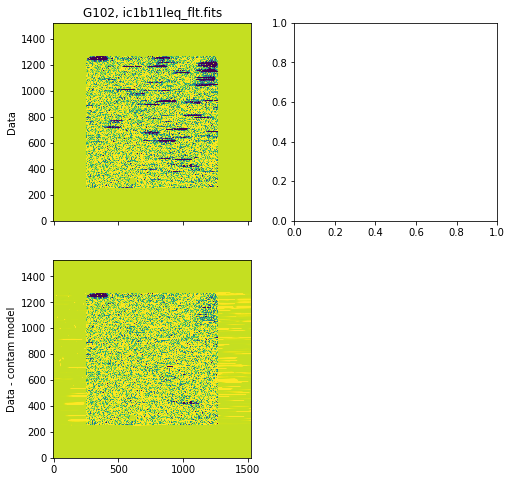

In [27]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting

In [28]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
print(pline) 

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=None, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

{'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}
Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [29]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

 
j130132m1138 LINE1  / 0.100" / pixf: 0.2 / point    / f105w
j130132m1138 LINE2  / 0.050" / pixf: 0.2 / point    / f105w
j130132m1138 LINE4  / 0.025" / pixf: 0.2 / point    / f105w
j130132m1138 DRIZ1  / 0.060" / pixf: 0.6 / square   / f105w
j130132m1138 DRIZ2  / 0.030" / pixf: 0.6 / square   / f105w
j130132m1138 DRIZ4  / 0.015" / pixf: 0.6 / square   / f105w


['j130132m1138-f105w_psf.fits'] 

Filename: j130132m1138-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


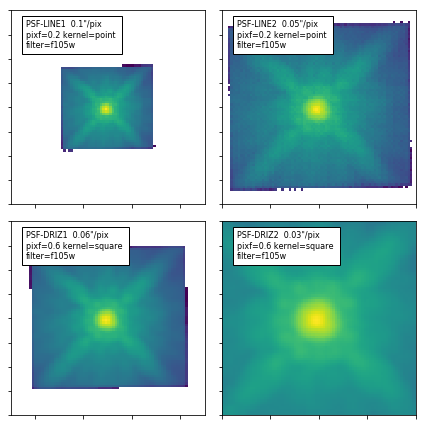

In [30]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [31]:
os.chdir('../Extractions')

In [32]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
tab['ra'] = [195.3959605,195.395979,195.3530178,195.3958188,195.3732336,195.3531173,195.3838585,195.3830377,195.366125,195.3883804,195.3947231,195.3933089,195.3811494,195.3686815,195.3640243,195.3718446,195.3799438,195.3708894,195.3845918,195.3646708,195.3653333,195.3601947,195.3676862,195.3637594,195.3937911,195.3765726,195.3656608,195.3747392,195.381325,195.3942565,195.39298,195.3650879,195.3745834,195.3939532,195.3764276,195.3783131,195.380938,195.3879146,195.3927553,195.3927867,195.3735954,195.3659456,195.3655294,195.373968,195.3771852,195.3733045,195.3682712,195.3758049,195.3888962,195.3717763,195.3951971,195.395458,195.3893949,195.3831935,195.3925091,195.375294,195.3805958,195.388787,195.3907159,195.3906625,195.3903453,195.3697507,195.3947093,195.3642162,195.3826468,195.366615,195.391293,195.3683571,195.3924226,195.3859218,195.3839547,195.3837731,195.391047,195.3909862,195.3864986,195.3908951,195.388712,195.3868905,195.390108,195.389979,195.3874533,195.370603,195.3947834,195.3606875,195.3792205,195.3709611,195.3786593,195.3783054,195.3748022,195.3628403,195.38649,195.3913432,195.3913993,195.3915933,195.3901767,195.3903123,195.3779043,195.3899304,195.3879009,195.3723669,195.3630413,195.3831453,195.378904,195.3737079,195.3658557,195.3807201,195.3697394,195.3892479,195.3671783,195.3767613,195.366126,195.3814135,195.3736331,195.3736584,195.3740118,195.390512,195.3939536,195.3773703,195.3647094,195.3616006,195.3809117,195.3881689,195.3875592,195.3837841,195.3697312,195.3697411,195.3693559,195.3609659,195.380774,195.3870689,195.3817226,195.3640662,195.3873664,195.3845397,195.3837087,195.3757212,195.3801517,195.3894559,195.3799206,195.3700076,195.3925059,195.3785669,195.3836637,195.3749831,195.3880376,195.3860217,195.37224,195.3666925,195.377695,195.3697053,195.3733665,195.388211,195.3942338,195.3929756,195.3825261,195.3799102,195.3839912,195.3918409,195.3621486,195.3712598,195.3705211,195.3923864,195.3691671,195.3892153,195.371968,195.3703901,195.3777766,195.386097,195.3896367,195.3671293,195.3742622,195.388413,195.3730798,195.3819873,195.3756507,195.3835655,195.3774702,195.3628516,195.3861982,195.3894146,195.3703345,195.3945986,195.3624812,195.3797579,195.3619166,195.3775146,195.3685547,195.3761245,195.384199,195.384327,195.388506,195.363727,195.3942165,195.362167,195.3817618,195.3932828,195.3672536,195.359488,195.3589469,195.364887,195.3742861,195.3586736,195.383637,195.3954183,195.3781793,195.3895607,195.3766097,195.3781673,195.3582326,195.363938,195.3739555,195.3735343,195.3738005,195.3921753,195.3919034,195.3604154,195.3918132,195.3574416,195.3812213,195.3779002,195.3939687,195.3708481,195.3831922,195.382904,195.3776574,195.357631,195.38338,195.3837064,195.3924828,195.3839286,195.3687862,195.3743906,195.3735139,195.3780474,195.3757432,195.3821085,195.3569363,195.3754865,195.3662344,195.3623945,195.3777687,195.3682384,195.3550698,195.3662231,195.3921367,195.3721258,195.3949047,195.3846922,195.3872738,195.3698141,195.3915249,195.3647625,195.3533511,195.3691983,195.3749797,195.3629302,195.3786294,195.3782618,195.3786826,195.3836707,195.3825548,195.3898395,195.3680391,195.378911,195.3852914,195.380885,195.3941029,195.3673873,195.3651677,195.377,195.3871214,195.3832837,195.3599524,195.3644739,195.3603362,195.3805272,195.3799406,195.3906569,195.3721601,195.3733866,195.3669049,195.39162,195.3562088,195.3772998,195.3945174,195.3869642,195.376504,195.3754751,195.378102,195.3737617,195.3659318,195.3875924,195.3728749,195.359113,195.3809503,195.3801102,195.3791885,195.3715003,195.3695591,195.3574324,195.3562319,195.3850381,195.3915062,195.3657991,195.3585532,195.3693005,195.3915541,195.3845064,195.3809484,195.3927977,195.3698569,195.3542645,195.3744944,195.3846207,195.3734888,195.3910744,195.377391,195.3694825,195.3776537,195.3716712]
tab['dec'] = [-11.64124317,-11.63882987,-11.60785561,-11.63883211,-11.63111072,-11.61469042,-11.64110497,-11.60737816,-11.6070323,-11.63904192,-11.64170913,-11.64144675,-11.6413302,-11.64114022,-11.64107255,-11.64103862,-11.64083636,-11.64082165,-11.64070512,-11.64049749,-11.64046416,-11.64048426,-11.64027763,-11.64031666,-11.6400538,-11.64076536,-11.64001213,-11.64002002,-11.63997923,-11.63983021,-11.6397776,-11.63976921,-11.63973829,-11.63953817,-11.63948751,-11.6395877,-11.63946594,-11.63895719,-11.63906197,-11.63892868,-11.63884426,-11.63870572,-11.63867338,-11.63844717,-11.63837661,-11.63837908,-11.63835567,-11.63856772,-11.63797681,-11.63800821,-11.6380308,-11.63794365,-11.63773284,-11.63752238,-11.63752896,-11.63737004,-11.63737595,-11.63728382,-11.63962842,-11.63898149,-11.63770154,-11.63698901,-11.63697406,-11.6367569,-11.63697327,-11.63662909,-11.63634714,-11.63619317,-11.63608512,-11.63608646,-11.63608772,-11.63610165,-11.63586002,-11.63575419,-11.63565666,-11.63552615,-11.63547892,-11.63519015,-11.63583286,-11.63528891,-11.63486003,-11.63482366,-11.63470407,-11.63472251,-11.63450717,-11.6343633,-11.6342125,-11.63442337,-11.63422026,-11.6341441,-11.63403648,-11.63434225,-11.63397477,-11.63509518,-11.63412621,-11.63393526,-11.63367413,-11.63361139,-11.63366546,-11.63354448,-11.6333945,-11.63321334,-11.63332672,-11.63267874,-11.63262291,-11.63245106,-11.63226004,-11.63216044,-11.63217713,-11.63210456,-11.63221531,-11.63206501,-11.63210248,-11.63199877,-11.63200403,-11.63191597,-11.63210237,-11.63177823,-11.6316475,-11.63176057,-11.63138111,-11.63124128,-11.63131519,-11.63106838,-11.63155507,-11.63130908,-11.63110264,-11.63069549,-11.630183,-11.63015099,-11.63007519,-11.63003784,-11.62995198,-11.62995384,-11.62969434,-11.62969395,-11.62949176,-11.62943742,-11.62932698,-11.62937934,-11.62921053,-11.62935057,-11.6289875,-11.62899812,-11.62893607,-11.62923641,-11.62855174,-11.62837063,-11.62836634,-11.62823163,-11.62834786,-11.62798498,-11.62806653,-11.62789367,-11.62773045,-11.62766155,-11.62757263,-11.62757321,-11.62711066,-11.62698947,-11.6269815,-11.62688043,-11.62663616,-11.62650529,-11.62621755,-11.62578861,-11.62558023,-11.6258339,-11.62540098,-11.62522001,-11.62511775,-11.62513016,-11.62508567,-11.6248879,-11.62476996,-11.62415317,-11.62396482,-11.62396404,-11.62389533,-11.62358228,-11.62364094,-11.62352567,-11.6233942,-11.62326359,-11.62344296,-11.62285719,-11.62278602,-11.62269422,-11.62233321,-11.62226374,-11.62228475,-11.62220327,-11.62216672,-11.62232362,-11.62210752,-11.62182292,-11.62149854,-11.6211737,-11.62101807,-11.62079351,-11.62075884,-11.62075754,-11.62082403,-11.620834,-11.62078189,-11.62055952,-11.62043338,-11.62042888,-11.62042022,-11.62046619,-11.62130131,-11.62110033,-11.62047843,-11.62036479,-11.62037512,-11.6202579,-11.62009452,-11.61989826,-11.61992057,-11.61987813,-11.61986408,-11.6197274,-11.61998642,-11.62013868,-11.6196542,-11.61958023,-11.61946154,-11.61939022,-11.6192921,-11.61924298,-11.61909486,-11.61914289,-11.61890348,-11.61905518,-11.61869402,-11.61859234,-11.61845893,-11.61842382,-11.6182128,-11.61811886,-11.61790007,-11.61787638,-11.61739196,-11.61699603,-11.61692087,-11.61670059,-11.61662313,-11.61638039,-11.6162284,-11.61601551,-11.61592482,-11.61591055,-11.61597429,-11.61596325,-11.61591421,-11.61580043,-11.6157808,-11.61581569,-11.61563218,-11.61542448,-11.61519757,-11.61520104,-11.61517008,-11.61491841,-11.61487509,-11.61475076,-11.61455811,-11.61445324,-11.61437334,-11.61445945,-11.61430013,-11.61438178,-11.61410627,-11.61388443,-11.61345984,-11.61331721,-11.61308335,-11.61296034,-11.61291749,-11.6128754,-11.61286521,-11.61276931,-11.61272539,-11.61269544,-11.61252133,-11.61256851,-11.61203799,-11.61197565,-11.61190124,-11.61168952,-11.61170816,-11.6118887,-11.61162368,-11.61150707,-11.61129745,-11.61117688,-11.61075842,-11.61052804,-11.61032904,-11.6101189,-11.61005101,-11.60995003,-11.60991246,-11.60986255,-11.60988401,-11.60960805,-11.60964866,-11.60946219,-11.60939456,-11.60929062,-11.609483,-11.60924466,-11.60910685,-11.60877485,-11.60803693,-11.60775932,-11.6076819,-11.60767777,-11.60754416,-11.60746341]
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

idx,ra,dec,id,dr
,deg,deg,,mas
0,195.3959605,-11.64124317,11,54.6
1,195.395979,-11.63882987,41,127.1
2,195.3530178,-11.60785561,391,12.4
3,195.3958188,-11.63883211,41,602.4
4,195.3732336,-11.63111072,127,67.2
5,195.3531173,-11.61469042,304,44.7
6,195.3838585,-11.64110497,9,42.2
7,195.3830377,-11.60737816,398,30.6
8,195.366125,-11.6070323,401,46.2


### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [33]:
id=source_ids[39]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 55 4
j130132m1138_00055.beams.fits


True

### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

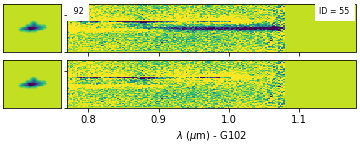

In [34]:
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

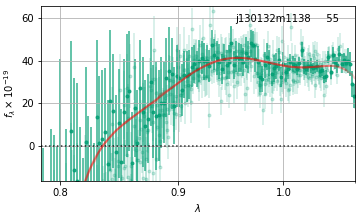

In [35]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run 55


(55, 1, 13.918330430984497)

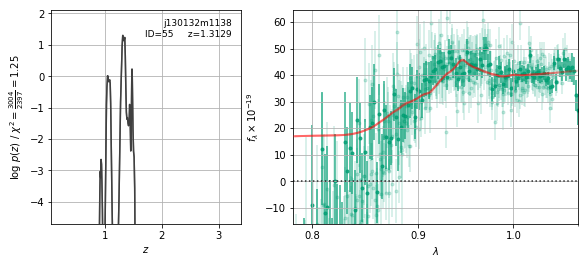

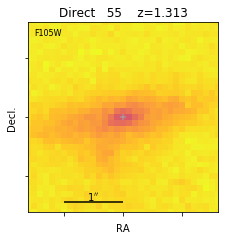

In [36]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
fitting.run_all_parallel(id)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [37]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j130132m1138_00055.stack.fits
j130132m1138_00055.log_par
j130132m1138_00055.full.fits
j130132m1138_00055.stack.png
j130132m1138_00055.beams.fits
j130132m1138_00055.1D.fits
j130132m1138_00055.full.png
j130132m1138_00055.1D.png
j130132m1138_00055.line.png


In [38]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()



j130132m1138_00055.stack.fits


Filename: j130132m1138_00055.stack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  SCI         G102,92.0 ImageHDU        54   (178, 64)   float32   
  2  WHT         G102,92.0 ImageHDU        22   (178, 64)   float32   
  3  CONTAM      G102,92.0 ImageHDU        22   (178, 64)   float32   
  4  MODEL       G102,92.0 ImageHDU        24   (178, 64)   float32   
  5  KERNEL      G102,92.0 ImageHDU        22   (64, 64)   float32   
  6  SCI         G102 ImageHDU        53   (178, 64)   float32   
  7  WHT         G102 ImageHDU        22   (178, 64)   float32   
  8  MODEL       G102 ImageHDU        24   (178, 64)   float32   
  9  KERNEL      G102 ImageHDU        22   (64, 64)   float32   


j130132m1138_00055.full.fits


Filename: j130132m1138_00055.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   ()      
  1  ZFIT_S

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [39]:
# Continuum source
id=source_ids[1]
auto_script.extract(field_root=root, ids=[id], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/1: 41 1
j130132m1138_00041.beams.fits


True

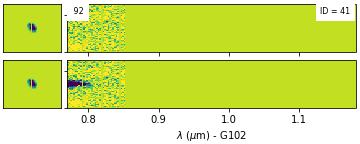

In [40]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

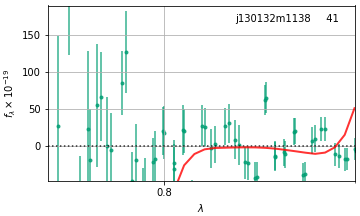

In [41]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

Run 41


(41, 1, 4.232531309127808)

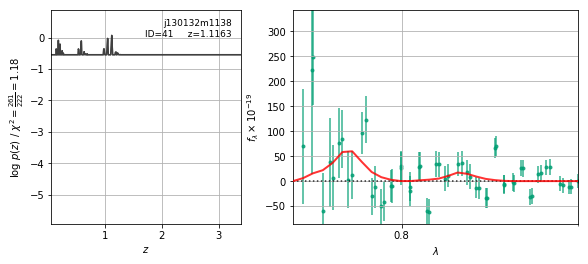

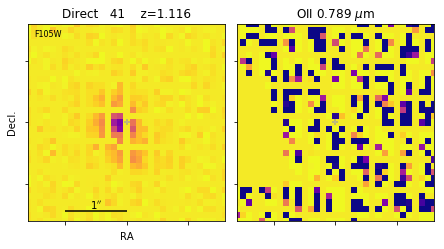

In [42]:
## Run the fit
fitting.run_all_parallel(id)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).